<a href="https://colab.research.google.com/github/UoB-DSMP-2023-24/dsmp-2024-group22/blob/main/TFTAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import storage
gcs = storage.Client()

In [3]:
import pandas as pd
import io

bucket_name = 'jpm-tapes'
directory_path = 'Tapes/'

bucket = gcs.get_bucket(bucket_name)

In [4]:
blobs = bucket.list_blobs(prefix=directory_path)

all_data_frames = []

for blob in blobs:
    if blob.name.endswith('.csv'):
        data = blob.download_as_bytes()
        data_io = io.BytesIO(data)
        df = pd.read_csv(data_io, names=['Time', 'Price', 'Quantity'])

        df['DateTime'] = pd.to_datetime(df['Time'], unit='s', origin=pd.Timestamp('2025-01-01'))
        df.set_index('DateTime', inplace=True)

        ohlc = df['Price'].resample('1T').ohlc()
        ohlc['Volume'] = df['Quantity'].resample('1T').sum()

        ohlc.reset_index(inplace=True)

        all_data_frames.append(ohlc)

final_data_frame = pd.concat(all_data_frames)

print(final_data_frame.head())
print()

final_data_frame.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']

             DateTime  open  high  low  close  Volume
0 2025-01-01 00:00:00   267   270  252    261      68
1 2025-01-01 00:01:00   259   267  254    265     106
2 2025-01-01 00:02:00   261   269  250    266      89
3 2025-01-01 00:03:00   269   269  258    261      86
4 2025-01-01 00:04:00   261   270  258    269      78



In [5]:
!pip install pytorch-forecasting pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 M

In [6]:
import pandas as pd
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl
import numpy as np

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import lightning.pytorch as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from sklearn.preprocessing import MinMaxScaler

In [7]:
final_data_frame['DateTime'] = pd.to_datetime(final_data_frame['DateTime'])
final_data_frame = final_data_frame.drop_duplicates(subset=['DateTime']).reset_index(drop=True)
final_data_frame['time_idx'] = (final_data_frame['DateTime'] - final_data_frame['DateTime'].min()).dt.total_seconds().astype(int)
final_data_frame['time_idx'] //= 60
final_data_frame['group_id'] = 'stock_price'
scaler = MinMaxScaler()
final_data_frame[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(final_data_frame[['Open', 'High', 'Low', 'Close', 'Volume']])

max_prediction_length = 5
max_encoder_length = 20
training_cutoff = final_data_frame['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    final_data_frame[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Open", "High", "Low", "Close", "Volume"],
    target_normalizer=GroupNormalizer(groups=["group_id"], transformation="log1p"),  # Changed transformation to log1p
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=100)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

trainer.fit(tft, train_dataloader, val_dataloader)


actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu()
predictions = tft.predict(val_dataloader).cpu()
predictions = torch.nan_to_num(predictions, nan=0.0)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
mae = (actuals - predictions).abs().mean()
print(mae)

import numpy as np
from sklearn.metrics import r2_score

mse = torch.mean((actuals - predictions) ** 2)
print("MSE:", mse.item())

mae = torch.mean(torch.abs(actuals - predictions))
print("MAE:", mae.item())

rmse = torch.sqrt(mse)
print("RMSE:", rmse.item())

actuals_np = actuals.numpy()
predictions_np = predictions.numpy()

r_squared = r2_score(actuals_np, predictions_np)
print("R-squared:", r_squared)


tensor(0.0488)
MSE: 0.004082744009792805
MAE: 0.04880928248167038
RMSE: 0.06389635056257248
R-squared: 0.9292569838296088


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

actuals_np = actuals.numpy()
predictions_np = predictions.numpy()

results_df = pd.DataFrame({
    'Actuals': actuals_np.flatten(),
    'Predictions': predictions_np.flatten()
})


results_df['DateTime'] = final_data_frame['DateTime'].iloc[-len(actuals_np):].reset_index(drop=True)


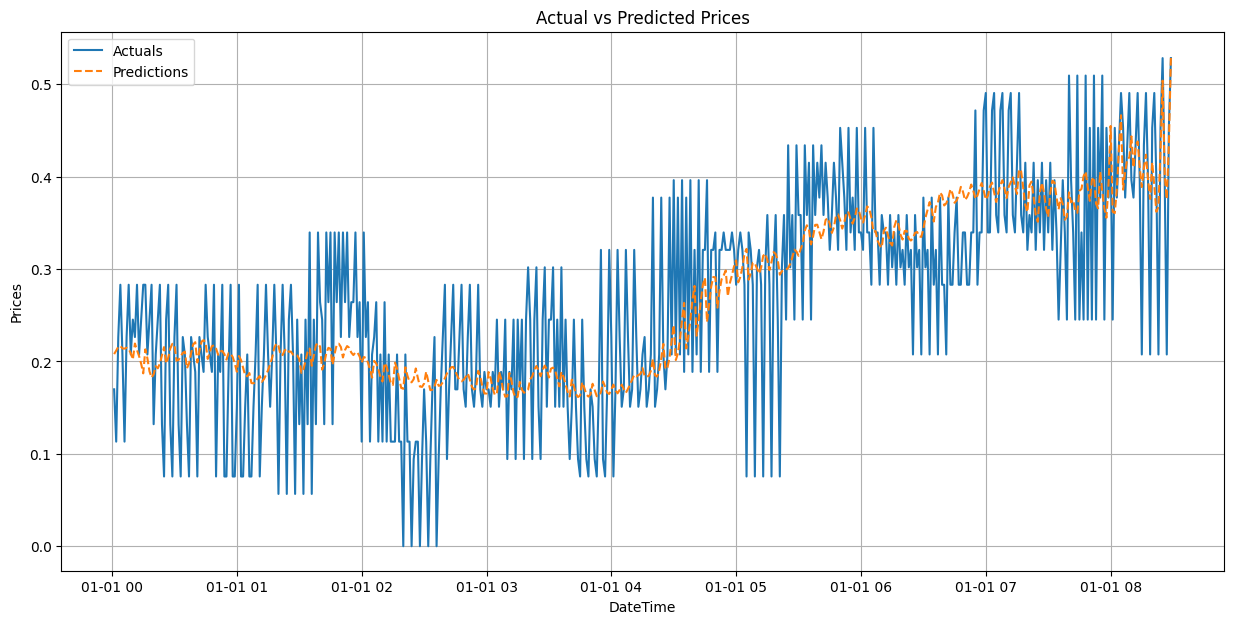

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(results_df['DateTime'], results_df['Actuals'], label='Actuals')
plt.plot(results_df['DateTime'], results_df['Predictions'], label='Predictions', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('DateTime')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['DateTime'], y=results_df['Actuals'],
                         mode='lines', name='Actuals'))
fig.add_trace(go.Scatter(x=results_df['DateTime'], y=results_df['Predictions'],
                         mode='lines+markers', name='Predictions', line=dict(dash='dash')))

fig.update_layout(title='Actual vs Predicted Prices (Original Scale)',
                  xaxis_title='DateTime',
                  yaxis_title='Price',
                  legend_title='Legend')
fig.show()


In [16]:
dummy_array = np.zeros((predictions_np.shape[0], 5))

dummy_array[:, 3] = predictions_np.flatten()

original_scale_predictions = scaler.inverse_transform(dummy_array)

original_scale_close_prices = original_scale_predictions[:, 3]



ValueError: could not broadcast input array from shape (2545,) into shape (509,)

In [14]:
results_df['Predictions_Original_Scale'] = original_scale_close_prices

plt.figure(figsize=(15, 7))
plt.plot(results_df['DateTime'], results_df['Actuals'], label='Actuals')
plt.plot(results_df['DateTime'], results_df['Predictions_Original_Scale'], label='Predictions', linestyle='--')
plt.title('Actual vs Predicted Prices on Original Scale')
plt.xlabel('DateTime')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'original_scale_close_prices' is not defined